# 使用Cifar10練習影像分類，遷移學習

In [1]:
#匯入函式庫，數值矩陣計算numpy，以及畫圖用的matplotlib
import numpy as np
import matplotlib.pyplot as plt

#匯入
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
#匯入tensorflow的函式庫，以及cifar10
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [3]:
#註：呼叫這些功能的寫法有兩種，以cifar10為例
#一、直接打一整串：tf.keras.datasets.cifar10.load_data()
#二、在一開始的地方使用from tensorflow.keras.datasets import cifar10，以後只要用cifar10.load_data()即可

## 讀取與檢視資料

In [4]:
#使用cifar10的資料集
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [5]:
X_train.shape

(50000, 32, 32, 3)

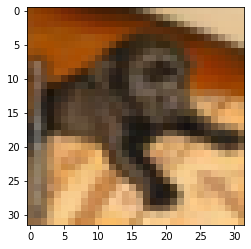

In [6]:
plt.imshow(X_train[56])

In [7]:
# 0 : airplain (飛機)
# 1 : automobile (汽車)
# 2 : bird (鳥)
# 3 : cat (貓)
# 4 : deer (鹿)
# 5 : dog (狗)
# 6 : frog (青蛙)
# 7 : horse (馬)
# 8 : ship (船)
# 9 : truck (卡車)

## 影像前處理

In [8]:
#對影像作正規化
x_train = X_train.astype('float32')/255
x_test = X_test.astype('float32')/255

In [9]:
#對類別資料作One-hot encoding
y_train = tf.keras.utils.to_categorical(Y_train)
y_test = tf.keras.utils.to_categorical(Y_test)

## 建立AI模型

In [10]:
#呼叫別人train好的模型，以resnet50為例
resmodel = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape = (32, 32, 3))

In [11]:
#resmodel.summary()

In [12]:
#進階
#設定權重的凍結
# for layer in resmodel.layers:
#     print(layer.name)
#     layer.trainable=False

In [13]:
#撰寫模型
input_layer=tf.keras.layers.Input(shape=(32,32,3))

x=resmodel(input_layer)
x=tf.keras.layers.GlobalAveragePooling2D()(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(16, activation='relu')(x)
x=tf.keras.layers.Dropout(0.3)(x)

output_layer=tf.keras.layers.Dense(10, activation='softmax')(x)

In [14]:
model=tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                32784     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170   

In [15]:
#data augmentation相關設定
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)  

## 開始訓練

In [17]:
#告訴AI學習的方式
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [18]:
#將訓練的模型置放於model_path下的model_name
model_name = 'cirfar10'

save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)

In [19]:
#設定模型存放方式(只存Validation表現最好的那一次)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

#設定多久沒進步就停下來
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1)

In [20]:
#開始訓練，順便把訓練過程存到model_history，方便後續畫圖
model_history=model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=70, 
                        steps_per_epoch=len(x_train)/32, validation_data=(x_test,y_test), callbacks=[earlystop, checkpoint])

Epoch 1/70
1562/1562 [==============================] - 74s 43ms/step - loss: 1.8232 - categorical_accuracy: 0.3794 - val_loss: 1.1013 - val_categorical_accuracy: 0.6526

Epoch 00001: val_loss improved from inf to 1.10126, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 2/70
1562/1562 [==============================] - 49s 31ms/step - loss: 1.3013 - categorical_accuracy: 0.5740 - val_loss: 1.0038 - val_categorical_accuracy: 0.6922

Epoch 00002: val_loss improved from 1.10126 to 1.00378, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 3/70
1562/1562 [==============================] - 76s 49ms/step - loss: 1.1069 - categorical_accuracy: 0.6445 - val_loss: 0.8339 - val_categorical_accuracy: 0.7441

Epoch 00003: val_loss improved from 1.00378 to 0.83393, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 4/70
1562/1562 [==============================] - 51s 32ms/step - loss: 1.0010 - categorical_accuracy: 0.6820 - val_loss: 0.8433 - val_categorical_accuracy: 0.7491

Epoch 00004: val_loss did not improve from 0.83393
Epoch 5/70
1562/1562 [==============================] - 51s 32ms/step - loss: 0.8950 - categorical_accuracy: 0.7189 - val_loss: 0.7391 - val_categorical_accuracy: 0.7685

Epoch 00005: val_loss improved from 0.83393 to 0.73905, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 6/70
1562/1562 [==============================] - 50s 32ms/step - loss: 0.8331 - categorical_accuracy: 0.7386 - val_loss: 0.7113 - val_categorical_accuracy: 0.7747

Epoch 00006: val_loss improved from 0.73905 to 0.71134, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 7/70
1562/1562 [==============================] - 50s 32ms/step - loss: 0.7903 - categorical_accuracy: 0.7507 - val_loss: 0.6545 - val_categorical_accuracy: 0.7951

Epoch 00007: val_loss improved from 0.71134 to 0.65455, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 8/70
1562/1562 [==============================] - 51s 33ms/step - loss: 0.7338 - categorical_accuracy: 0.7693 - val_loss: 0.6305 - val_categorical_accuracy: 0.8071

Epoch 00008: val_loss improved from 0.65455 to 0.63046, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 9/70
1562/1562 [==============================] - 51s 32ms/step - loss: 0.6985 - categorical_accuracy: 0.7808 - val_loss: 0.5773 - val_categorical_accuracy: 0.8127

Epoch 00009: val_loss improved from 0.63046 to 0.57732, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 10/70
1562/1562 [==============================] - 51s 32ms/step - loss: 0.6708 - categorical_accuracy: 0.7905 - val_loss: 0.6447 - val_categorical_accuracy: 0.7933

Epoch 00010: val_loss did not improve from 0.57732
Epoch 11/70
1562/1562 [==============================] - 52s 33ms/step - loss: 0.6404 - categorical_accuracy: 0.8014 - val_loss: 0.5702 - val_categorical_accuracy: 0.8253

Epoch 00011: val_loss improved from 0.57732 to 0.57023, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 12/70
1562/1562 [==============================] - 51s 33ms/step - loss: 0.6196 - categorical_accuracy: 0.8085 - val_loss: 0.7057 - val_categorical_accuracy: 0.7722

Epoch 00012: val_loss did not improve from 0.57023
Epoch 13/70
1562/1562 [==============================] - 50s 32ms/step - loss: 0.6397 - categorical_accuracy: 0.7995 - val_loss: 0.5859 - val_categorical_accuracy: 0.8183

Epoch 00013: val_loss did not improve from 0.57023
Epoch 14/70
1562/1562 [==============================] - 52s 33ms/step - loss: 0.5802 - categorical_accuracy: 0.8198 - val_loss: 0.5251 - val_categorical_accuracy: 0.8418

Epoch 00014: val_loss improved from 0.57023 to 0.52512, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 15/70
1562/1562 [==============================] - 52s 33ms/step - loss: 0.5625 - categorical_accuracy: 0.8261 - val_loss: 0.4789 - val_categorical_accuracy: 0.8530

Epoch 00015: val_loss improved from 0.52512 to 0.47890, saving model to /home/h282475249/image_classification/saved_models/cirfar10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 16/70
1562/1562 [==============================] - 51s 33ms/step - loss: 0.5273 - categorical_accuracy: 0.8364 - val_loss: 0.5120 - val_categorical_accuracy: 0.8427

Epoch 00016: val_loss did not improve from 0.47890
Epoch 17/70
1562/1562 [==============================] - 52s 33ms/step - loss: 0.5293 - categorical_accuracy: 0.8385 - val_loss: 0.5171 - val_categorical_accuracy: 0.8405

Epoch 00017: val_loss did not improve from 0.47890
Epoch 18/70
1562/1562 [==============================] - 52s 33ms/step - loss: 0.5030 - categorical_accuracy: 0.8460 - val_loss: 0.4937 - val_categorical_accuracy: 0.8498

Epoch 00018: val_loss did not improve from 0.47890
Epoch 19/70
1562/1562 [==============================] - 53s 34ms/step - loss: 0.4900 - categorical_accuracy: 0.8464 - val_loss: 0.5051 - val_categorical_accuracy: 0.8490

Epoch 00019: val_loss did not improve from 0.47890
Epoch 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 30/70
1562/1562 [==============================] - 53s 34ms/step - loss: 0.4046 - categorical_accuracy: 0.8767 - val_loss: 0.5390 - val_categorical_accuracy: 0.8496

Epoch 00030: val_loss did not improve from 0.46971
Epoch 31/70
1562/1562 [==============================] - 52s 34ms/step - loss: 0.3652 - categorical_accuracy: 0.8882 - val_loss: 0.6761 - val_categorical_accuracy: 0.8516

Epoch 00031: val_loss did not improve from 0.46971
Epoch 32/70
1562/1562 [==============================] - 53s 34ms/step - loss: 0.3667 - categorical_accuracy: 0.8880 - val_loss: 0.5096 - val_categorical_accuracy: 0.8517

Epoch 00032: val_loss did not improve from 0.46971
Epoch 33/70
1562/1562 [==============================] - 53s 34ms/step - loss: 0.3501 - categorical_accuracy: 0.8936 - val_loss: 0.5838 - val_categorical_accuracy: 0.8414

Epoch 00033: val_loss did not improve from 0.46971
Epoch 

## 畫圖

In [21]:
model_history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [22]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

training_acc = model_history.history['categorical_accuracy']
val_acc = model_history.history['val_categorical_accuracy']

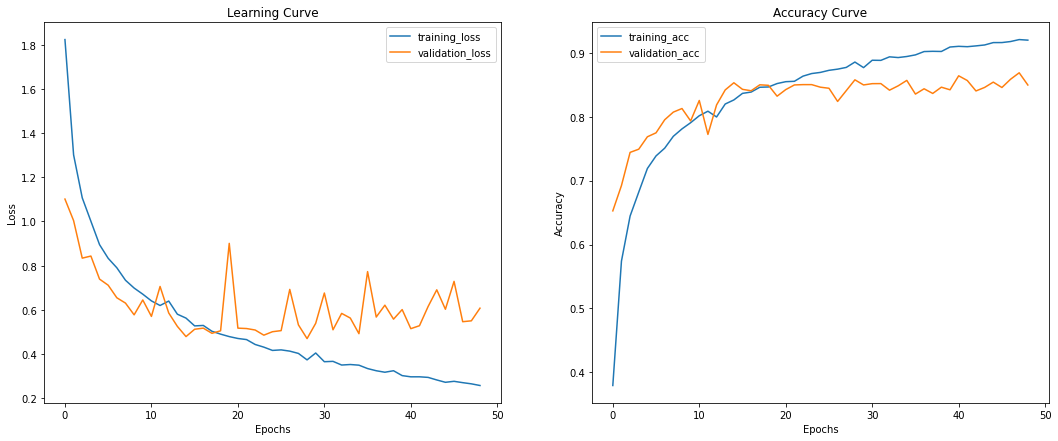

In [23]:
#畫圖
plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.legend(loc='upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc='best')

plt.show()

## 作預測

In [24]:
#載入訓練好的模型
model = tf.keras.models.load_model(model_path)

In [25]:
#使用AI模型作預測
pred=model.predict(x_test)

In [26]:
#將預測的機率轉換成類別
ans=np.argmax(pred, axis=-1)

In [27]:
#畫出混淆矩陣
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(Y_test, ans)
print(cf_matrix)

[[877  25  17  13   5   2   7  13  27  14]
 [  6 940   5   2   0   0   1   0   9  37]
 [ 25   2 826  39  34  15  35  16   3   5]
 [ 10   4  34 737  41  75  30  51  11   7]
 [ 11   1  33  31 847  15  24  35   2   1]
 [  5   3  20 156  26 725  12  45   3   5]
 [  9   0  23  46   4   2 903   7   1   5]
 [  7   1   4  15  26  21   3 914   2   7]
 [ 54  23   4   9   2   0   1   2 894  11]
 [ 11  51   1   5   0   0   0   7  12 913]]


<AxesSubplot:>

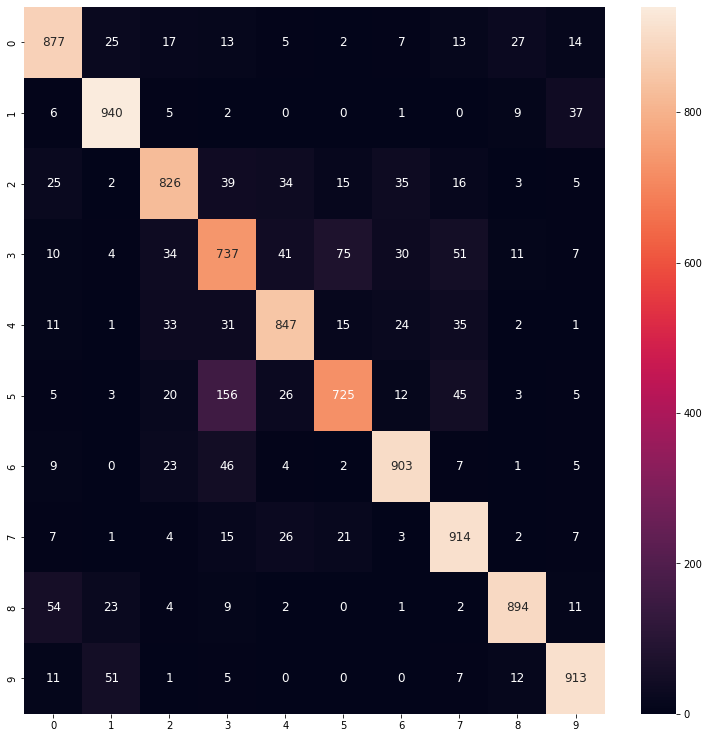

In [28]:
#對混淆矩陣畫圖
import seaborn as sns
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(cf_matrix, fmt='g', annot=True, annot_kws={"size":12})

In [29]:
#計算統計指標
from sklearn.metrics import classification_report
report = classification_report(Y_test, ans)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       0.90      0.94      0.92      1000
           2       0.85      0.83      0.84      1000
           3       0.70      0.74      0.72      1000
           4       0.86      0.85      0.85      1000
           5       0.85      0.72      0.78      1000
           6       0.89      0.90      0.90      1000
           7       0.84      0.91      0.87      1000
           8       0.93      0.89      0.91      1000
           9       0.91      0.91      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

